<a href="https://colab.research.google.com/github/PaulScotti/algonauts2025/blob/cindyhfls/algonauts_2025_challenge_model_training_cindyhfls.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Preparation: install relevant packages, import libraries and mount data drive**

In [6]:
!pip install ipywidgets
!pip install nilearn
!pip install himalaya
!pip install -q voxelwise_tutorials # for utility functions such as explainable_variance
!pip install datasets
from datasets import load_dataset

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.8/83.8 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 9.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 40.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.3/86.3 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.6/139.6 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.8/148.8 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 80.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.4/84.4 kB 5.4 MB/s eta 0:00:00


In [2]:
dataset = load_dataset("medarc/AlgonautsDS-features", streaming=True)
# Still experimenting if we can just load the features from hugging face without downloading it

Repo card metadata block was not found. Setting CardData to empty.


In [ ]:
import os
from pathlib import Path
import glob
import re
import numpy as np
import pandas as pd
import h5py
import torch
import librosa
import ast
import string
import zipfile
from tqdm.notebook import tqdm
from sklearn.linear_model import RidgeCV, Ridge
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import pearsonr
import cv2
import nibabel as nib
from nilearn import plotting
from nilearn.maskers import NiftiLabelsMasker
import ipywidgets as widgets
from ipywidgets import VBox, Dropdown, Button
import matplotlib.pyplot as plt

In [ ]:
# Mount your Google Drive to this Colab notebook
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
root_data_dir = '/content/drive/MyDrive/algonauts_2025_challenge_tutorial_data'
save_data_dir = '/content/drive/MyDrive/algonauts_2025_challenge_cindyhfls'
models_dir = os.path.join(save_data_dir, 'trained_encoding_models')
figs_dir = os.path.join(save_data_dir, 'Figures')


Mounted at /content/drive/


In [ ]:
def convert_vector_to_nii(parcel_resp, subject):
    """
    Convert the parcellated data (e.g. fMRI activity, beta weights, encoding accuracy etc. to nii for plotting)

    Parameters
    ----------
    parcel_resp : float
        fMRI responses or beta weights etc. shape (1000,)
    subject : int
        Subject number used to train and validate the encoding model.
    """
    atlas_file = f'sub-0{subject}_space-MNI152NLin2009cAsym_atlas-Schaefer18_parcel-1000Par7Net_desc-dseg_parcellation.nii.gz'
    atlas_path = os.path.join(root_data_dir, 'algonauts_2025.competitors',
        'fmri', f'sub-0{subject}', 'atlas', atlas_file)
    atlas_masker = NiftiLabelsMasker(labels_img=atlas_path)
    atlas_masker.fit()
    parcel_resp_nii = atlas_masker.inverse_transform(parcel_resp)
    return parcel_resp_nii

## Calculate explainable variance for each subject

In [ ]:
def load_fmri_movie10_repeats(root_data_dir, subject):
    """
    Load the fMRI responses for the selected subject.

    Parameters
    ----------
    root_data_dir : str
        Root data directory.
    subject : int
        Subject used to train and validate the encoding model.

    Returns
    -------
    fmri : dict
        Dictionary containing the  fMRI responses.

    Since some of the movies in movie 10 were repeated, we will use this to calculate the explainable variance (noise ceiling)
    For fMRI responses to Movie10, fMRI datasets were saved within .h5 files (one per subject) according to the naming convention ses-<recording_session>_task-<movie><movie_split>_run-<run_number>, where:

    recording_session: Number indicating the fMRI recording session (movie splits were acquired over multiple sessions spread over many days).
    movie: String indicating the movie name.
    movie_split: Number indicating the movie split.
    run_number: Number (1 or 2) indicating whether the movie was presented for the first or second time. Only applies to datasets for movies Life and Hidden figures, since these two movies were presented twice to each subject (whereas all other movies were only presented once).
        return fmri[keys_movie]
    """
    fmri = {}

    ### Load the fMRI responses for Movie10 ###
    # Data directory
    fmri_file = f'sub-0{subject}_task-movie10_space-MNI152NLin2009cAsym_atlas-Schaefer18_parcel-1000Par7Net_bold.h5'
    fmri_dir = os.path.join(root_data_dir, 'algonauts_2025.competitors',
        'fmri', f'sub-0{subject}', 'func', fmri_file)
    # Load the the fMRI responses
    fmri_movie10 = h5py.File(fmri_dir, 'r')
    for key, val in fmri_movie10.items():
        fmri[key[13:]] = val[:].astype(np.float32)
    del fmri_movie10

    keys_all = fmri.keys()
    run1,run2 = [],[]
    figures_splits = 12
    for s in range(figures_splits):
        movie = 'figures' + format(s+1, '02')
        keys_movie = [rep for rep in keys_all if movie in rep]
        # print(keys_movie)
        run1.append(fmri[keys_movie[0]])
        run2.append(fmri[keys_movie[1]])

    # Average the fMRI responses across the two repeats for 'life'
    keys_all = fmri.keys()
    life_splits = 5
    for s in range(life_splits):
        movie = 'life' + format(s+1, '02')
        keys_movie = [rep for rep in keys_all if movie in rep]
        # print(keys_movie)
        run1.append(fmri[keys_movie[0]])
        run2.append(fmri[keys_movie[1]])

    run1 = np.concatenate(run1,axis=0)
    run2 = np.concatenate(run2,axis=0)
    ### Output ###
    return run1,run2

(n_repeats, n_samples_test, n_voxels) = (2, 6871, 1000)


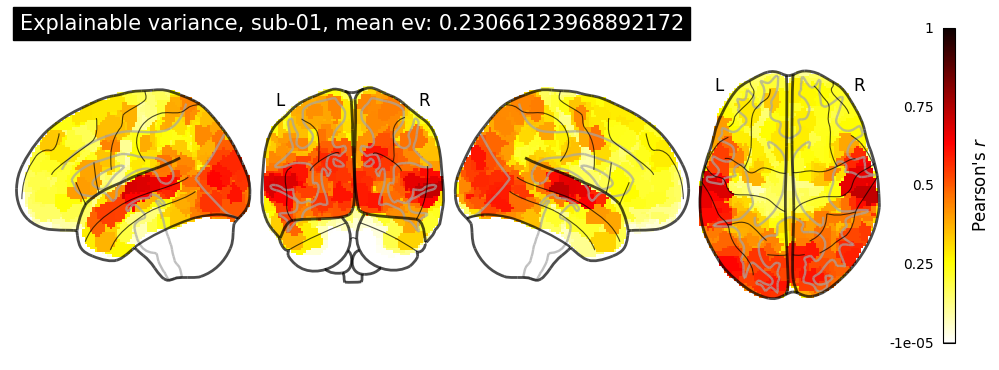

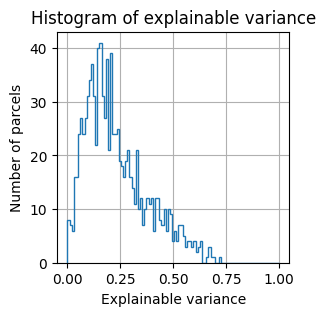

(n_repeats, n_samples_test, n_voxels) = (2, 6871, 1000)


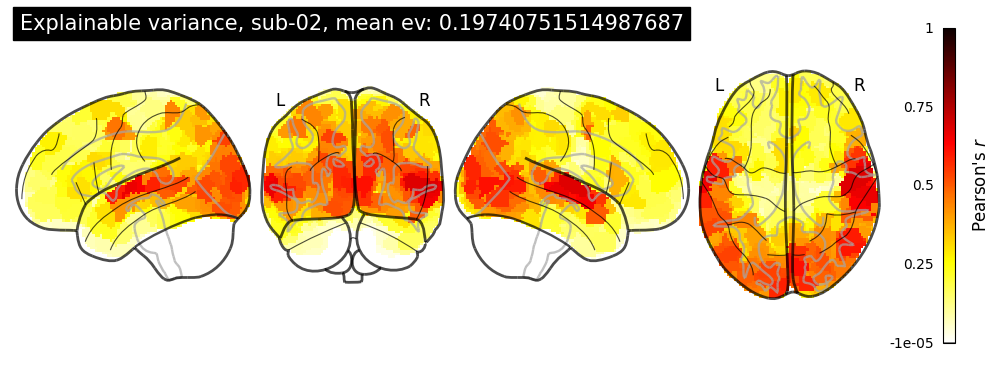

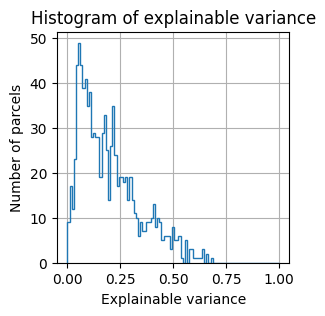

(n_repeats, n_samples_test, n_voxels) = (2, 6871, 1000)


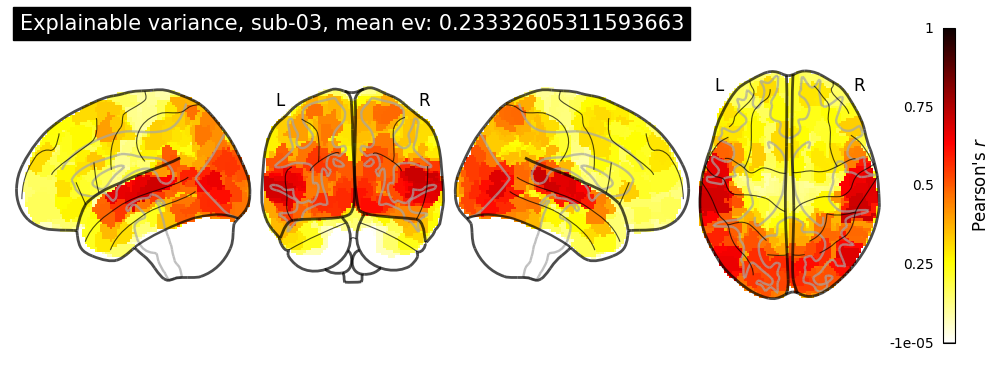

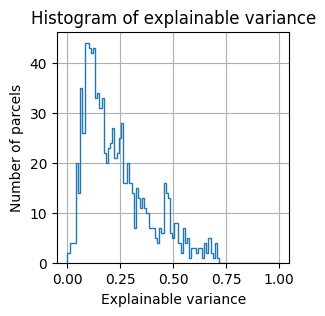

(n_repeats, n_samples_test, n_voxels) = (2, 6871, 1000)


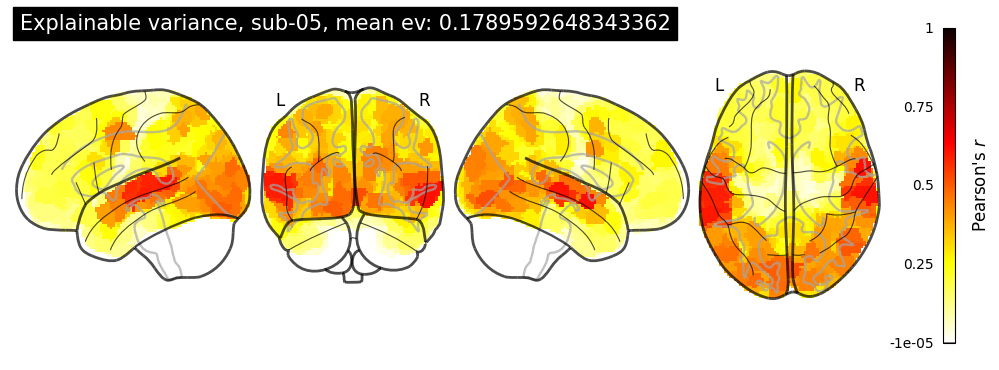

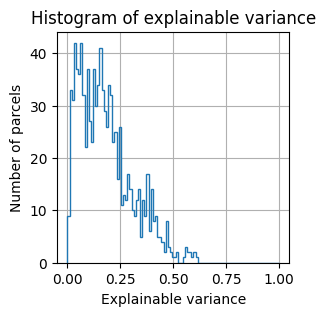

In [ ]:
for subject in [1,2,3,5]:
    run1,run2 = load_fmri_movie10_repeats(root_data_dir, subject)
    Y_test = np.stack((run1, run2), axis=0)
    from voxelwise_tutorials.utils import explainable_variance
    print("(n_repeats, n_samples_test, n_voxels) =", Y_test.shape)
    ev = explainable_variance(Y_test)
    np.savetxt(os.path.join(save_data_dir,"explainable_variance",f"ExplainableVariance_sub-0{subject}.txt"),ev)
    ### Plot the spatial distribution of encoding accuracy ###
    parcel_resp_nii = convert_vector_to_nii(ev, subject)
    title = f"Explainable variance, sub-0{subject}, mean ev: " + str(ev.mean())

    display = plotting.plot_glass_brain(
        parcel_resp_nii,
        display_mode="lyrz",
        cmap='hot_r',
        colorbar=True,
        plot_abs=False,
        symmetric_cbar=False,
        vmin=0,
        vmax=1,
        resampling_interpolation='nearest',
        title=title,
    )
    colorbar = display._cbar
    # colorbar.set_label("Pearson's $r$", rotation=90, labelpad=12, fontsize=12)
    plt.savefig(os.path.join(figs_dir,f"ExplainableVariance_sub-0{subject}_glassbrain.png"),bbox_inches='tight')
    plotting.show()

    plt.figure(figsize=(3,3))
    plt.hist(ev, bins=np.linspace(0, 1, 100), log=False, histtype='step')
    plt.xlabel("Explainable variance")
    plt.ylabel("Number of parcels")
    plt.title('Histogram of explainable variance')
    plt.grid('on')
    plt.savefig(os.path.join(figs_dir,f"ExplainableVariance_sub-0{subject}_histogram.png"),bbox_inches='tight')
    plt.show()

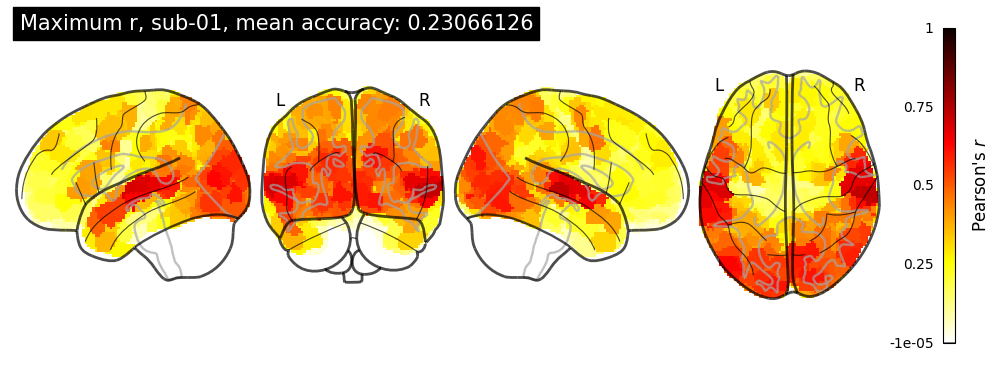

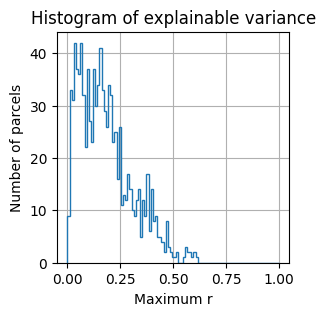

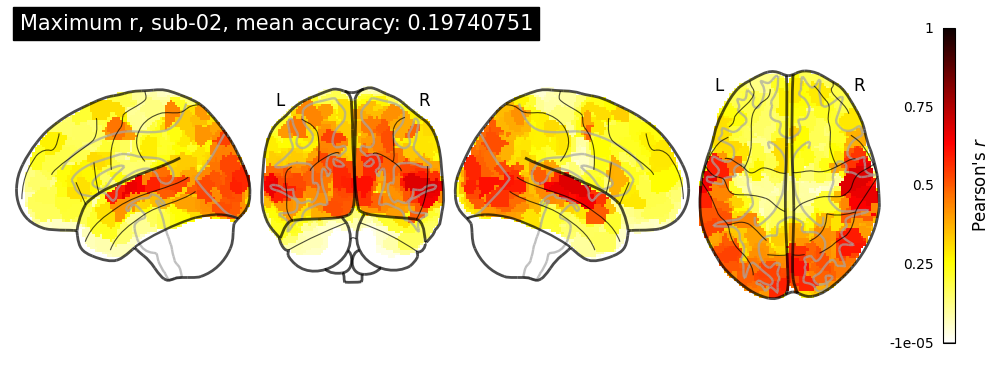

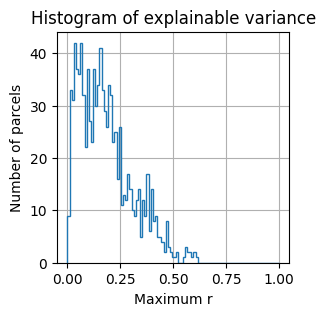

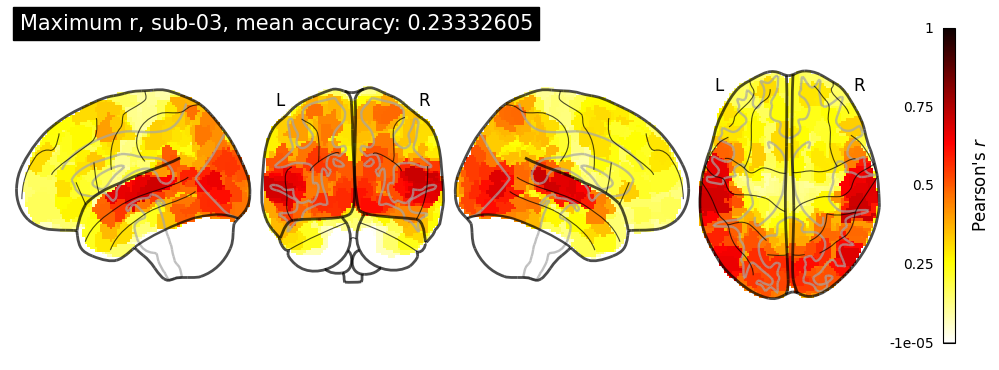

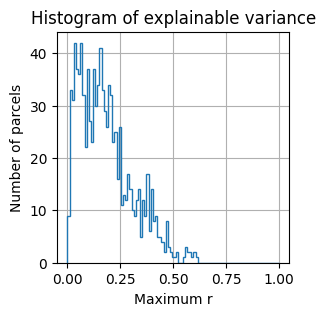

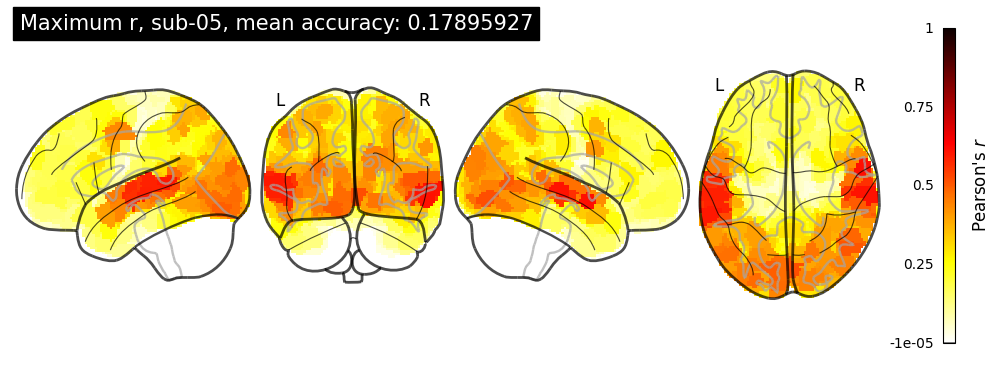

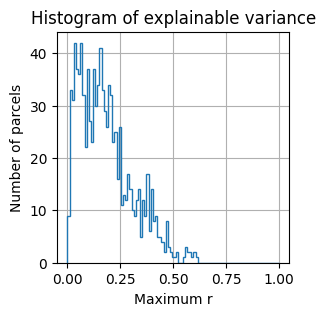

In [ ]:
for subject in [1,2,3,5]:
    run1,run2 = load_fmri_movie10_repeats(root_data_dir, subject)
    ### Plot the spatial distribution of encoding accuracy ###
    max_accuracy = np.zeros((run1.shape[1]), dtype=np.float32)
    for p in range(len(max_accuracy)):
        max_accuracy[p] = pearsonr(run1[:, p],
            run2[:, p])[0]
    np.savetxt(os.path.join(save_data_dir,"explainable_variance",f"Maxr_sub-0{subject}.txt"),max_accuracy)
    parcel_resp_nii = convert_vector_to_nii(max_accuracy, subject)
    title = f"Maximum r, sub-0{subject}, mean accuracy: " + str(max_accuracy.mean())

    display = plotting.plot_glass_brain(
        parcel_resp_nii,
        display_mode="lyrz",
        cmap='hot_r',
        colorbar=True,
        plot_abs=False,
        symmetric_cbar=False,
        vmin=0,
        vmax=1,
        resampling_interpolation='nearest',
        title=title,
    )
    colorbar = display._cbar
    colorbar.set_label("Pearson's $r$", rotation=90, labelpad=12, fontsize=12)
    plt.savefig(os.path.join(figs_dir,f"Maxr_sub-0{subject}_glassbrain.png"),bbox_inches='tight')
    plotting.show()

    plt.figure(figsize=(3,3))
    plt.hist(ev, bins=np.linspace(0, 1, 100), log=False, histtype='step')
    plt.xlabel("Maximum r")
    plt.ylabel("Number of parcels")
    plt.title('Histogram of explainable variance')
    plt.grid('on')
    plt.savefig(os.path.join(figs_dir,f"Maxr_sub-0{subject}_histogram.png"),bbox_inches='tight')
    plt.show()

## Encoding model training with extracted features (section 3 in tutorial, the ones provided by the tutorial are the PCs with 250 for movies and language and 20 for auditory features)

In [ ]:
# To-do: load other the stimulus from hugging face (hopefully stored as PCs already or we can have a function here to run PCA on the features):
# https://huggingface.co/datasets/medarc/AlgonautsChallenge25/

In [ ]:
def load_stimulus_features(root_data_dir, modality):
    """
    Load the stimulus features.

    Parameters
    ----------
    root_data_dir : str
        Root data directory.
    modality : str
        Used feature modality.

    Returns
    -------
    features : dict
        Dictionary containing the stimulus features.

    """

    features = {}

    ### Load the visual features ###
    if modality == 'visual' or modality == 'all':
        stimuli_dir = os.path.join(root_data_dir, 'stimulus_features', 'pca',
            'friends_movie10', 'visual', 'features_train.npy')
        features['visual'] = np.load(stimuli_dir, allow_pickle=True).item()

    ### Load the audio features ###
    if modality == 'audio' or modality == 'all':
        stimuli_dir = os.path.join(root_data_dir, 'stimulus_features', 'pca',
            'friends_movie10', 'audio', 'features_train.npy')
        features['audio'] = np.load(stimuli_dir, allow_pickle=True).item()

    ### Load the language features ###
    if modality == 'language' or modality == 'all':
        stimuli_dir = os.path.join(root_data_dir, 'stimulus_features', 'pca',
            'friends_movie10', 'language', 'features_train.npy')
        features['language'] = np.load(stimuli_dir, allow_pickle=True).item()

    ### Output ###
    return features

In [ ]:
# Modified from load_stimulus_features
# To-do: integrate with hugging face so that we can save our features there

def load_stimulus_feature_spaces(root_data_dir, feature_names, raw_or_pca='pca', movie_name='friends_movie10'):
    """
    Load the stimulus features.

    Parameters
    ----------
    root_data_dir : str
        Root data directory.
    feature_names : list
        Used feature type in a list. e.g. ["motion_energy","slow_r50"]
    raw_or_pca : str

    Returns
    -------
    features : dict
        Dictionary containing the stimulus features.

    """

    features = {}
    for idx, feature_space in enumerate(feature_names):
        stimuli_dir = os.path.join(save_data_dir, 'stimulus_features',raw_or_pca,movie_name, feature_space, 'features_train.npy')
        features[feature_space] = np.load(stimuli_dir, allow_pickle=True).item()

In [ ]:
def load_fmri(root_data_dir, subject):
    """
    Load the fMRI responses for the selected subject.

    Parameters
    ----------
    root_data_dir : str
        Root data directory.
    subject : int
        Subject used to train and validate the encoding model.

    Returns
    -------
    fmri : dict
        Dictionary containing the  fMRI responses.

    """

    fmri = {}

    ### Load the fMRI responses for Friends ###
    # Data directory
    fmri_file = f'sub-0{subject}_task-friends_space-MNI152NLin2009cAsym_atlas-Schaefer18_parcel-1000Par7Net_desc-s123456_bold.h5'
    fmri_dir = os.path.join(root_data_dir, 'algonauts_2025.competitors',
        'fmri', f'sub-0{subject}', 'func', fmri_file)
    # Load the the fMRI responses
    fmri_friends = h5py.File(fmri_dir, 'r')
    for key, val in fmri_friends.items():
        fmri[str(key[13:])] = val[:].astype(np.float32)
    del fmri_friends

    ### Load the fMRI responses for Movie10 ###
    # Data directory
    fmri_file = f'sub-0{subject}_task-movie10_space-MNI152NLin2009cAsym_atlas-Schaefer18_parcel-1000Par7Net_bold.h5'
    fmri_dir = os.path.join(root_data_dir, 'algonauts_2025.competitors',
        'fmri', f'sub-0{subject}', 'func', fmri_file)
    # Load the the fMRI responses
    fmri_movie10 = h5py.File(fmri_dir, 'r')
    for key, val in fmri_movie10.items():
        fmri[key[13:]] = val[:].astype(np.float32)
    del fmri_movie10
    # Average the fMRI responses across the two repeats for 'figures'
    keys_all = fmri.keys()
    figures_splits = 12
    for s in range(figures_splits):
        movie = 'figures' + format(s+1, '02')
        keys_movie = [rep for rep in keys_all if movie in rep]
        fmri[movie] = ((fmri[keys_movie[0]] + fmri[keys_movie[1]]) / 2).astype(np.float32)
        del fmri[keys_movie[0]]
        del fmri[keys_movie[1]]
    # Average the fMRI responses across the two repeats for 'life'
    keys_all = fmri.keys()
    life_splits = 5
    for s in range(life_splits):
        movie = 'life' + format(s+1, '02')
        keys_movie = [rep for rep in keys_all if movie in rep]
        fmri[movie] = ((fmri[keys_movie[0]] + fmri[keys_movie[1]]) / 2).astype(np.float32)
        del fmri[keys_movie[0]]
        del fmri[keys_movie[1]]

    ### Output ###
    return fmri

In [ ]:
def align_features_and_fmri_samples(features, fmri, excluded_samples_start,
    excluded_samples_end, hrf_delay, stimulus_window, movies):
    """
    Align the stimulus feature with the fMRI response samples for the selected
    movies, later used to train and validate the encoding models.

    Parameters
    ----------
    features : dict
        Dictionary containing the stimulus features.
    fmri : dict
        Dictionary containing the fMRI responses.
    excluded_trs_start : int
        Integer indicating the first N fMRI TRs that will be excluded and not
        used for model training. The reason for excluding these TRs is that due
        to the latency of the hemodynamic response the fMRI responses of first
        few fMRI TRs do not yet contain stimulus-related information.
    excluded_trs_end : int
        Integer indicating the last N fMRI TRs that will be excluded and not
        used for model training. The reason for excluding these TRs is that
        stimulus feature samples (i.e., the stimulus chunks) can be shorter than
        the fMRI samples (i.e., the fMRI TRs), since in some cases the fMRI run
        ran longer than the actual movie. However, keep in mind that the fMRI
        timeseries onset is ALWAYS SYNCHRONIZED with movie onset (i.e., the
        first fMRI TR is always synchronized with the first stimulus chunk).
    hrf_delay : int
        fMRI detects the BOLD (Blood Oxygen Level Dependent) response, a signal
        that reflects changes in blood oxygenation levels in response to
        activity in the brain. Blood flow increases to a given brain region in
        response to its activity. This vascular response, which follows the
        hemodynamic response function (HRF), takes time. Typically, the HRF
        peaks around 5–6 seconds after a neural event: this delay reflects the
        time needed for blood oxygenation changes to propagate and for the fMRI
        signal to capture them. Therefore, this parameter introduces a delay
        between stimulus chunks and fMRI samples for a better correspondence
        between input stimuli and the brain response. For example, with a
        hrf_delay of 3, if the stimulus chunk of interest is 17, the
        corresponding fMRI sample will be 20.
    stimulus_window : int
        Integer indicating how many stimulus features' chunks are used to model
        each fMRI TR, starting from the chunk corresponding to the TR of
        interest, and going back in time. For example, with a stimulus_window of
        5, if the fMRI TR of interest is 20, it will be modeled with stimulus
        chunks [16, 17, 18, 19, 20]. Note that this only applies to visual and
        audio features, since the language features were already extracted using
        transcript words spanning several movie chunks (thus, each fMRI TR will
        only be modeled using the corresponding language feature chunk). Also
        note that a larger stimulus window will increase compute time, since it
        increases the amount of stimulus features used to train and test the
        fMRI encoding models.
    movies: list
        List of strings indicating the movies for which the fMRI responses and
        stimulus features are aligned, out of the first six seasons of Friends
        ["friends-s01", "friends-s02", "friends-s03", "friends-s04",
        "friends-s05", "friends-s06"], and the four movies from Movie10
        ["movie10-bourne", "movie10-figures", "movie10-life", "movie10-wolf"].

    Returns
    -------
    aligned_features : float
        Aligned stimulus features for the selected movies.
    aligned_fmri : float
        Aligned fMRI responses for the selected movies.

    """

    ### Empty data variables ###
    aligned_features = []
    aligned_fmri = np.empty((0,1000), dtype=np.float32)

    ### Loop across movies ###
    for movie in movies:

        ### Get the IDs of all movies splits for the selected movie ###
        if movie[:7] == 'friends':
            id = movie[8:]
        elif movie[:7] == 'movie10':
            id = movie[8:]
        movie_splits = [key for key in fmri if id in key[:len(id)]]

        ### Loop over movie splits ###
        for split in movie_splits:

            ### Extract the fMRI ###
            fmri_split = fmri[split]
            # Exclude the first and last fMRI samples
            fmri_split = fmri_split[excluded_samples_start:-excluded_samples_end]
            aligned_fmri = np.append(aligned_fmri, fmri_split, 0)

            ### Loop over fMRI samples ###
            for s in range(len(fmri_split)):
                # Empty variable containing the stimulus features of all
                # modalities for each fMRI sample
                f_all = np.empty(0)

                ### Loop across modalities ###
                for mod in features.keys():

                    ### Visual and audio features ###
                    # If visual or audio modality, model each fMRI sample using
                    # the N stimulus feature samples up to the fMRI sample of
                    # interest minus the hrf_delay (where N is defined by the
                    # 'stimulus_window' variable)
                    if mod == 'visual' or mod == 'audio':
                        # In case there are not N stimulus feature samples up to
                        # the fMRI sample of interest minus the hrf_delay (where
                        # N is defined by the 'stimulus_window' variable), model
                        # the fMRI sample using the first N stimulus feature
                        # samples
                        if s < (stimulus_window + hrf_delay):
                            idx_start = excluded_samples_start
                            idx_end = idx_start + stimulus_window
                        else:
                            idx_start = s + excluded_samples_start - hrf_delay \
                                - stimulus_window + 1
                            idx_end = idx_start + stimulus_window
                        # In case there are less visual/audio feature samples
                        # than fMRI samples minus the hrf_delay, use the last N
                        # visual/audio feature samples available (where N is
                        # defined by the 'stimulus_window' variable)
                        if idx_end > (len(features[mod][split])):
                            idx_end = len(features[mod][split])
                            idx_start = idx_end - stimulus_window
                        f = features[mod][split][idx_start:idx_end]
                        f_all = np.append(f_all, f.flatten())

                    ### Language features ###
                    # Since language features already consist of embeddings
                    # spanning several samples, only model each fMRI sample
                    # using the corresponding stimulus feature sample minus the
                    # hrf_delay
                    elif mod == 'language':
                        idx = s + excluded_samples_start - hrf_delay
                        # In case there are fewer language feature samples than
                        # fMRI samples minus the hrf_delay, use the last
                        # language feature sample available
                        if idx >= (len(features[mod][split]) - hrf_delay):
                            f = features[mod][split][-1,:]
                        else:
                            f = features[mod][split][idx]
                        f_all = np.append(f_all, f.flatten())

                 ### Append the stimulus features of all modalities for this sample ###
                aligned_features.append(f_all)

    ### Convert the aligned features to a numpy array ###
    aligned_features = np.asarray(aligned_features, dtype=np.float32)

    ### Output ###
    return aligned_features, aligned_fmri

In [ ]:
# Define all encoding models
def train_encoding(encoding_model_name,features_train=0, fmri_train=0, alphavals=[1,10,100],no_fit=False):
    """
    Train a linear-regression-based encoding model to predict fMRI responses
    using movie features.

    Parameters
    ----------
    features_train : float
        Stimulus features for the training movies.
    fmri_train : float
        fMRI responses for the training movies.
    encoding_model_name : string
        name for the encoding model to use

    Returns
    -------
    model : object
        Trained regression model.

    """
    ### Set backend of Himalaya to use GPU if available
    if ('himalaya' in encoding_model_name) and (torch.cuda.is_available()):
        from himalaya.backend import set_backend
        backend = set_backend("torch_cuda", on_error="warn")
        features_train = features_train.astype("float32")

    ### Train the linear regression model ###
    if encoding_model_name == 'sklearn_LinearRegression':
        model = LinearRegression()
        if not no_fit:
            model.fit(features_train, fmri_train)
    elif encoding_model_name == 'sklearn_RidgeCV':
        model = RidgeCV()
        if not no_fit:
            model.fit(features_train,fmri_train)
    elif encoding_model_name == 'himalaya_RidgeCV':
        from himalaya.ridge import RidgeCV as himalaya_RidgeCV
        model = himalaya_RidgeCV(alphas = alphavals)
        if not no_fit:
            model.fit(features_train,fmri_train)
    elif encoding_model_name == 'himalaya_BandedRidgeCV': # for multiple feature spaces
        from himalaya.ridge import BandedRidgeCV as himalaya_BandedRidgeCV
        model = himalaya_BandedRidgeCV()
        if not no_fit:
            model.fit(features_train,fmri_train)
    else:
         raise ValueError("'Encoding model name not found!")

    ### Output ###
    return model

In [ ]:
def plot_fmri_sample(parcel_resp_nii, cbar_label="Pearson's $r$",vmin=-2,vmax=2,cmap='bwr',title='',save_path=[]):
    """
    Plot one frame of fmri response or anything in the shape of (1000,)

    Parameters
    ----------
    parcel_resp_nii : float
        fMRI responses or beta weights etc.
    cbar_label : string
        Colorbar meaning
    """

    ### Plot the encoding accuracy ###
    display = plotting.plot_glass_brain(
        parcel_resp_nii,
        display_mode="lyrz",
        cmap=cmap,
        colorbar=True,
        plot_abs=False,
        symmetric_cbar=True,
        vmin=vmin,
        vmax=vmax,
        resampling_interpolation='nearest',
        title=title,
    )
    colorbar = display._cbar
    colorbar.set_label(cbar_label, rotation=90, labelpad=12, fontsize=12)
    if save_path:
        plt.savefig(save_path,bbox_inches='tight')

    plotting.show()

In [ ]:
# Load the stimulus features (this is independent of hrf_delay and stimulus_window so we can only load it once)

modality = "all"  #@param ["visual", "audio", "language", "all"]

features = load_stimulus_features(root_data_dir, modality)

# Print all available movie splits for each stimulus modality
for key_modality, value_modality in features.items():
    print(f"\n{key_modality} features movie splits name and shape:")
    for key_movie, value_movie in value_modality.items():
        print(key_movie + " " + str(value_movie.shape))


visual features movie splits name and shape:
s01e01a (591, 250)
s01e01b (590, 250)
s01e02a (482, 250)
s01e02b (482, 250)
s01e03a (472, 250)
s01e03b (472, 250)
s01e04a (502, 250)
s01e04b (502, 250)
s01e05a (468, 250)
s01e05b (468, 250)
s01e06a (488, 250)
s01e06b (488, 250)
s01e07a (492, 250)
s01e07b (492, 250)
s01e08a (475, 250)
s01e08b (475, 250)
s01e09a (467, 250)
s01e09b (467, 250)
s01e10a (495, 250)
s01e10b (495, 250)
s01e11a (476, 250)
s01e11b (476, 250)
s01e12a (471, 250)
s01e12b (471, 250)
s01e13a (468, 250)
s01e13b (467, 250)
s01e14a (491, 250)
s01e14b (491, 250)
s01e15a (476, 250)
s01e15b (476, 250)
s01e16a (482, 250)
s01e16b (482, 250)
s01e17a (482, 250)
s01e17b (482, 250)
s01e18a (496, 250)
s01e18b (496, 250)
s01e19a (460, 250)
s01e19b (460, 250)
s01e20a (460, 250)
s01e20b (460, 250)
s01e21a (476, 250)
s01e21b (476, 250)
s01e22a (473, 250)
s01e22b (473, 250)
s01e23a (461, 250)
s01e23b (461, 250)
s01e24a (514, 250)
s01e24b (514, 250)
s02e01a (476, 250)
s02e01b (476, 250)
s02e

In [ ]:
# Load the fMRI responses (this is independent of hrf_delay and stimulus_window so we can only load it once)
# for movie10 Each movie was presented to each subject once, except for Life and Hidden Figures which were presented twice

subject = 5  #@param ["1", "2", "3", "5"] {type:"raw", allow-input: true}

fmri = load_fmri(root_data_dir, subject)

# Print all available movies
# print(f"Subject {subject} fMRI movies splits name and shape:")
# for key, value in fmri.items():
#     print(key + " " + str(value.shape))

# Align the stimulus features with the fMRI responses for the training movies
excluded_samples_start = 5  #@param {type:"slider", min:0, max:20, step:1}

excluded_samples_end = 5  #@param {type:"slider", min:0, max:20, step:1}

hrf_delay = 3  #@param {type:"slider", min:0, max:10, step:1}

stimulus_window = 5  #@param {type:"slider", min:1, max:20, step:1} # how much history to use

movies_train = ["friends-s01", "friends-s02", "friends-s03", "friends-s04", "friends-s05", "movie10-bourne", "movie10-figures", "movie10-life", "movie10-wolf"] # @param {allow-input: true}

movies_val = ["friends-s06"] # @param {allow-input: true}

features_train, fmri_train = align_features_and_fmri_samples(features, fmri,
    excluded_samples_start, excluded_samples_end, hrf_delay, stimulus_window,
    movies_train)

# Print the shape of the training fMRI responses and stimulus features: note
# that the two have the same sample size!
print("Training fMRI responses shape:")
print(fmri_train.shape)
print('(Train samples × Parcels)')
print("\nTraining stimulus features shape:")
print(features_train.shape)
print('(Train samples × Features)')

# Align the stimulus features with the fMRI responses for the validation movies
features_val, fmri_val = align_features_and_fmri_samples(features, fmri,
    excluded_samples_start, excluded_samples_end, hrf_delay, stimulus_window,
    movies_val)

# Print the shape of the test fMRI responses and stimulus features: note
# that the two have the same sample size!
print("Validation fMRI responses shape:", fmri_val.shape)
print('(Validation samples × Parcels)')
print("\nValidation stimulus features shape:", features_val.shape)
print('(Validation samples × Features)')

Training fMRI responses shape:
(128162, 1000)
(Train samples × Parcels)

Training stimulus features shape:
(128162, 1600)
(Train samples × Features)
Validation fMRI responses shape: (22924, 1000)
(Validation samples × Parcels)

Validation stimulus features shape: (22924, 1600)
(Validation samples × Features)


In [ ]:
# Load existing models
encoding_model_name = 'sklearn_LinearRegression'
modality = 'all'

weights_dir = os.path.join(save_data_dir,'trained_encoding_models')
file_name = f'trained_encoding_model_sub-0{subject}_modality-{modality}_{encoding_model_name}.npy'  # s is the subject identifier
file_path = os.path.join(weights_dir, file_name)
model_weights = np.load(file_path,allow_pickle=True).item()
model = train_encoding(encoding_model_name,no_fit=True)
model.coef_ = model_weights['coef_']
model.intercept_ = model_weights['intercept_']
model.n_features_in_ = model_weights['n_features_in_']

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/algonauts_2025_challenge_cindyhfls/trained_encoding_models/trained_encoding_model_sub-05_modality-all_sklearn_LinearRegression.npy'

In [ ]:
# OR Train the encoding model
encoding_model_name = 'sklearn_LinearRegression'

# Define the directory and file name
weights_dir = os.path.join(save_data_dir,'trained_encoding_models')
file_name = f'trained_encoding_model_sub-0{subject}_modality-{modality}_{encoding_model_name}.npy'  # s is the subject identifier
file_path = os.path.join(weights_dir, file_name)

model = train_encoding(encoding_model_name,features_train=features_train, fmri_train=fmri_train)
# Save the model
# Prepare the dictionary with necessary attributes
model_weights = {
    'coef_': model.coef_,
    'intercept_': model.intercept_,
    'n_features_in_': model.n_features_in_
}

# Save the dictionary to a .npy file with pickling
np.save(file_path, model_weights, allow_pickle=True)

# print(model.coef_.shape) # nROIs x nFeatures (1000,1600)
# print(model.intercept_.shape) #nROIs (1000,)
# print(model.n_features_in_) # nFeatures 1600

## Test the models

In [ ]:
# Predict the fMRI responses for the validation movies
fmri_val_pred = model.predict(features_val)

# Print the shape of the recorded and predicted test fMRI responses: note that
# the two have the same shape!
print("Validation fMRI responses shape:", fmri_val.shape)
print('(Validation samples × Parcels)')
print("\nValidation predicted fMRI responses shape:", fmri_val_pred.shape)
print('(Validation samples × Parcels)')

Validation fMRI responses shape: (22924, 1000)
(Validation samples × Parcels)

Validation predicted fMRI responses shape: (22924, 1000)
(Validation samples × Parcels)


In [ ]:
# Calculate encoding accuracy for each parcel (spatial)
encoding_accuracy = np.zeros((fmri_val.shape[1]), dtype=np.float32)
for p in range(len(encoding_accuracy)):
    encoding_accuracy[p] = pearsonr(fmri_val[:, p],
        fmri_val_pred[:, p])[0]
mean_encoding_accuracy = np.mean(encoding_accuracy)

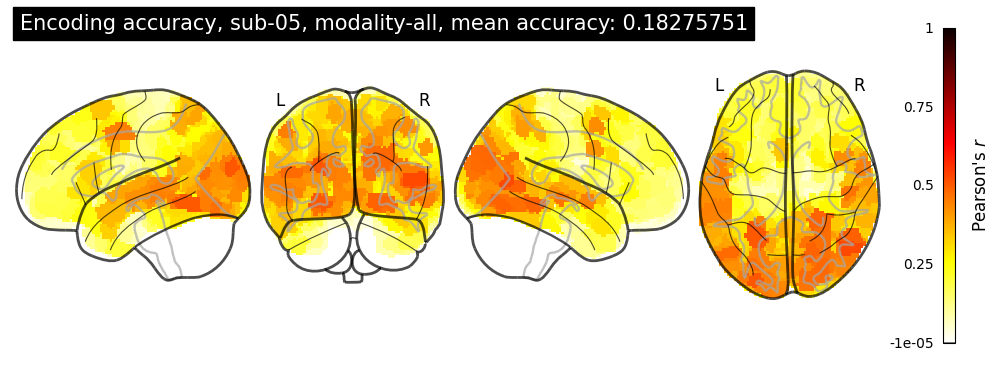

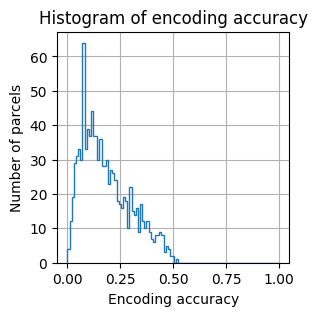

In [ ]:
### Plot the spatial distribution of encoding accuracy ###
parcel_resp_nii = convert_vector_to_nii(encoding_accuracy, subject)
title = f"Encoding accuracy, sub-0{subject}, modality-{modality}, mean accuracy: " + str(mean_encoding_accuracy)

display = plotting.plot_glass_brain(
    parcel_resp_nii,
    display_mode="lyrz",
    cmap='hot_r',
    colorbar=True,
    plot_abs=False,
    symmetric_cbar=False,
    vmin=0,
    vmax=1,
    resampling_interpolation='nearest',
    title=title,
)
colorbar = display._cbar
colorbar.set_label("Pearson's $r$", rotation=90, labelpad=12, fontsize=12)
plt.savefig(os.path.join(figs_dir,f"EncodingAccuracy_sub-0{subject}_glassbrain.png"),bbox_inches='tight')
plotting.show()

plt.figure(figsize=(3,3))
plt.hist(encoding_accuracy, bins=np.linspace(0, 1, 100), log=False,histtype='step')
plt.xlabel("Encoding accuracy")
plt.ylabel("Number of parcels")
plt.title('Histogram of encoding accuracy')
plt.grid('on')
plt.savefig(os.path.join(figs_dir,f"EncodingAccuracy_sub-0{subject}_histogram.png"),bbox_inches='tight')
plt.show()

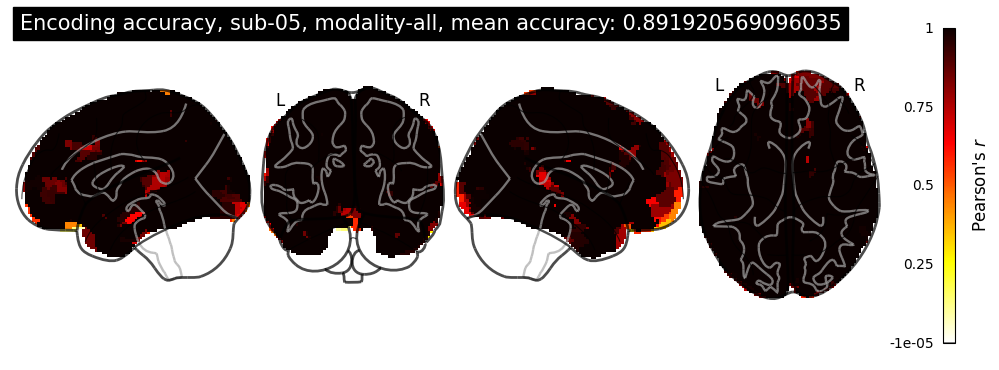

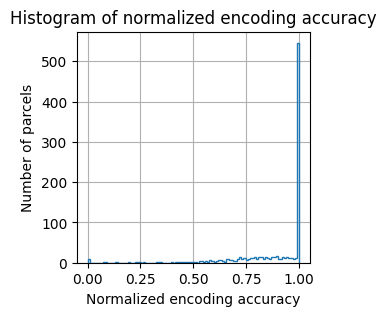

In [ ]:
### Plot the spatial distribution of normalized encoding accuracy ###
# ev = np.loadtxt(os.path.join(save_data_dir,'explainable_variance',f"ExplainableVariance_sub-0{subject}.txt"))
ev = np.loadtxt(os.path.join(save_data_dir,'explainable_variance',f"Maxr_sub-0{subject}.txt"))

encoding_accuracy_norm = encoding_accuracy/ev
encoding_accuracy_norm[encoding_accuracy_norm<0] = 0
encoding_accuracy_norm[encoding_accuracy_norm>1] = 1

parcel_resp_nii = convert_vector_to_nii(encoding_accuracy_norm, subject)
title = f"Encoding accuracy, sub-0{subject}, modality-{modality}, mean accuracy: " + str(np.mean(encoding_accuracy_norm))

display = plotting.plot_glass_brain(
    parcel_resp_nii,
    display_mode="lyrz",
    cmap='hot_r',
    colorbar=True,
    plot_abs=False,
    symmetric_cbar=False,
    vmin=0,
    vmax=1,
    resampling_interpolation='nearest',
    title=title,
)
colorbar = display._cbar
colorbar.set_label("Pearson's $r$", rotation=90, labelpad=12, fontsize=12)
plt.savefig(os.path.join(figs_dir,f"NormalizedEncodingAccuracy_sub-0{subject}_glassbrain.png"),bbox_inches='tight')
plotting.show()

plt.figure(figsize=(3,3))
plt.hist(encoding_accuracy_norm, bins=np.linspace(0, 1, 100), log=False, histtype='step')
plt.xlabel("Normalized encoding accuracy")
plt.ylabel("Number of parcels")
plt.title('Histogram of normalized encoding accuracy')
plt.grid('on')
plt.savefig(os.path.join(figs_dir,f"NormalizedEncodingAccuracy_sub-0{subject}_histogram.png"),bbox_inches='tight')
plt.show()

In [ ]:
# Calculate encoding accuracy for each TR (temporal)
encoding_accuracy_t = np.zeros((fmri_val.shape[0]), dtype=np.float32)
for p in range(len(encoding_accuracy_t)):
    encoding_accuracy_t[p] = pearsonr(fmri_val[p,:],
        fmri_val_pred[p, :])[0]
mean_encoding_accuracy_t = np.mean(encoding_accuracy_t)

KeyboardInterrupt: 

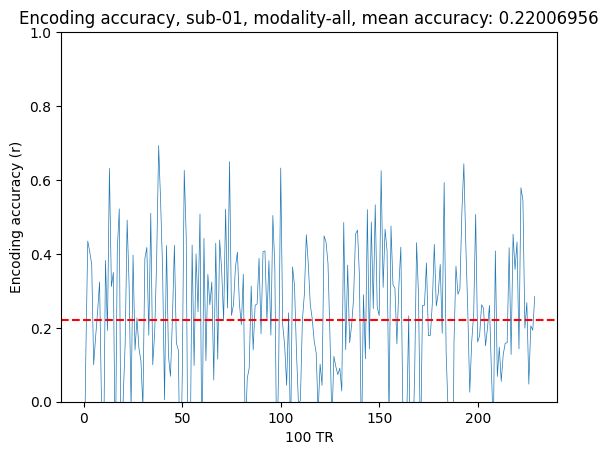

In [ ]:
# Plot the encoding accuracy over time (To-do: add vertical lines to show where each episodes start/end)
title = f"Encoding accuracy, sub-0{subject}, modality-{modality}, mean accuracy: " + str(mean_encoding_accuracy_t)

k = 100 # subsample
plt.plot(encoding_accuracy_t[::k],lw=0.5)
plt.axhline(y=mean_encoding_accuracy_t, color='r', linestyle='--')
plt.ylabel('Encoding accuracy (r)')
plt.xlabel(f'{k} TR')
plt.title(title)
plt.ylim([0,1])
plt.show()
plt.fontsize=15

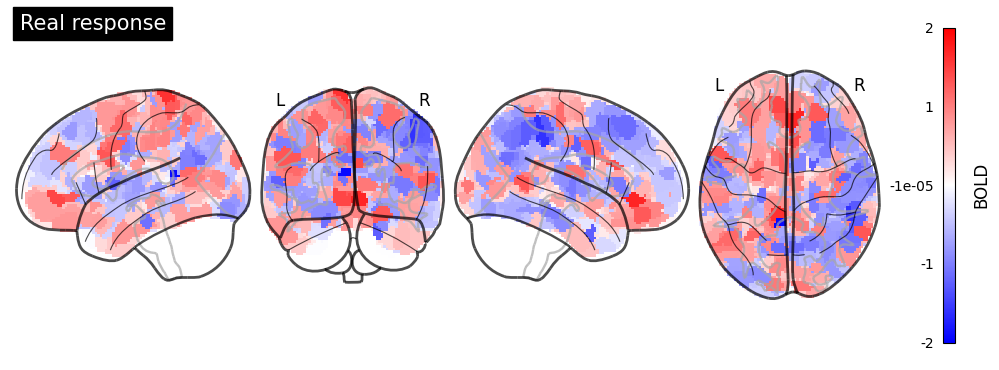

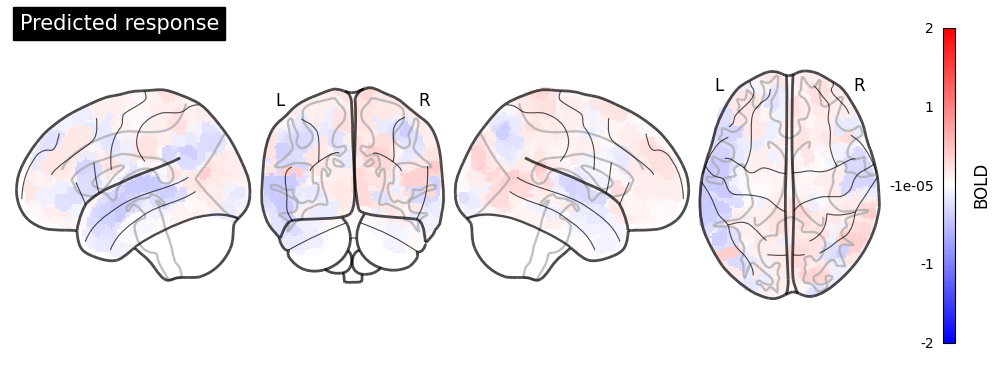

In [ ]:
### Plot examples of true data and predicted data ###
iTR = 1500 # which frame
plot_fmri_sample(convert_vector_to_nii(fmri_val[iTR,], subject), cbar_label="BOLD",title="Real response",save_path=os.path.join(figs_dir,f"ExampleRealResponse_sub-0{subject}_glassbrain.png"))
plot_fmri_sample(convert_vector_to_nii(fmri_val_pred[iTR,], subject), cbar_label="BOLD",title="Predicted response",save_path=os.path.join(figs_dir,f"ExamplePredictedResponse_sub-0{subject}_glassbrain.png"))

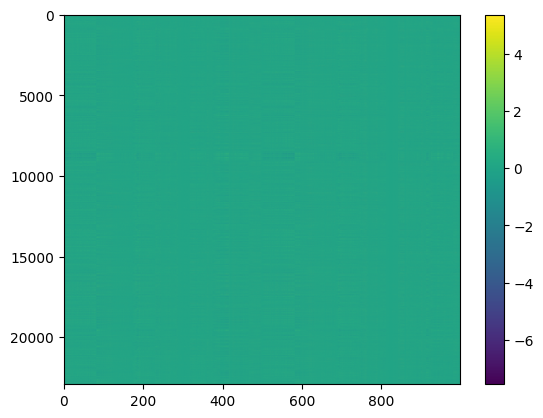

In [ ]:
plt.imshow(fmri_val-fmri_val_pred,aspect='auto')
plt.colorbar()
plt.show()


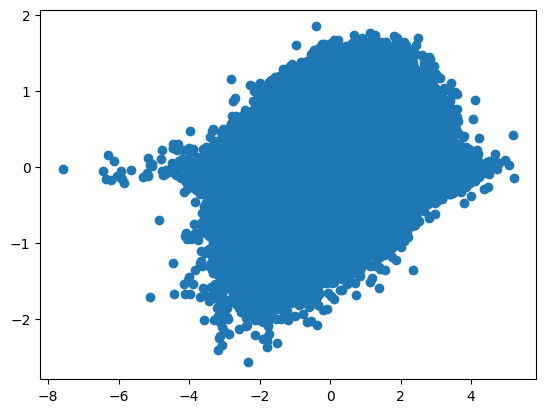

In [ ]:
plt.scatter(fmri_val,fmri_val_pred)